In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pygan.generativeadversarialnetworks.adversarial_auto_encoders import AdversarialAutoEncoders
from pygan.gansvaluefunction.margin_loss import MarginLoss

In [3]:
from pygan.generativemodel.autoencodermodel.convolutional_auto_encoder import ConvolutionalAutoEncoder as Generator

In [4]:
#from pygan.discriminativemodel.cnn_model import CNNModel as Discriminator
from pygan.discriminativemodel.autoencodermodel.convolutional_auto_encoder import ConvolutionalAutoEncoder as Discriminator

In [5]:
from pygan.truesampler.image_true_sampler import ImageTrueSampler

In [6]:
from pygan.noisesampler.image_noise_sampler import ImageNoiseSampler
from pygan.noisesampler.gauss_noise_sampler import GaussNoiseSampler

In [7]:
# First convolution layer.
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
# Second convolution layer.
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
# Computation graph in output layer.
from pydbm.synapse.cnn_output_graph import CNNOutputGraph
# Computation graph for first convolution layer.
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
# Computation graph for second convolution layer.
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# ReLu Function as activation function.
from pydbm.activation.relu_function import ReLuFunction
# SGD optimizer.
from pydbm.optimization.optparams.sgd import SGD

In [8]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pygan")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

In [9]:
batch_size = 20
width = 100
height = 100
channel = 3

image_dir = "../../../../Downloads/rgb/"
seq_len = None
gray_scale_flag = False
wh_size_tuple = (width, height)
norm_mode = "z_score"

In [10]:
true_sampler = ImageTrueSampler(
    batch_size=batch_size,
    image_dir=image_dir,
    seq_len=seq_len,
    gray_scale_flag=gray_scale_flag,
    wh_size_tuple=wh_size_tuple,
    norm_mode=norm_mode
)

(20, 3, 100, 100)
(-2.760557593304846, -1.5158245029548805e-17, 3.8491931399118458)


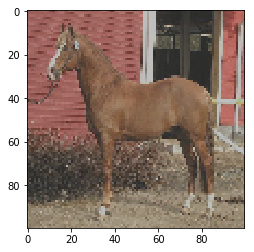

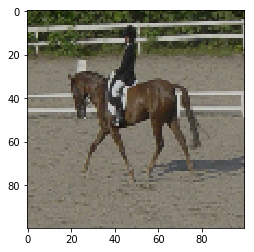

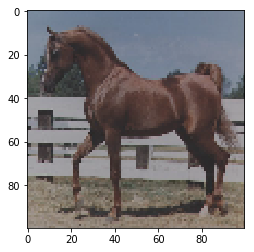

In [11]:
arr = true_sampler.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
def plot(arr):
    arr = 255 * (arr - arr.min()) / (arr.max() - arr.min())
    arr = arr.transpose(0, 2, 3, 1).astype(np.uint8)
    for i in range(3):
        plt.imshow(arr[i, :]);
        plt.show()
        plt.close()
plot(arr)

In [12]:
noise_sampler = ImageNoiseSampler(
    batch_size,
    image_dir,
    seq_len=None,
    gray_scale_flag=gray_scale_flag,
    wh_size_tuple=wh_size_tuple,
    norm_mode=norm_mode
)

(20, 3, 100, 100)
(-2.8815468671162563, 2.2737367544323208e-18, 5.049583506093696)


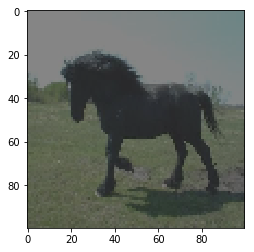

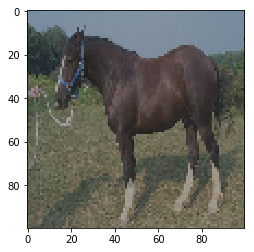

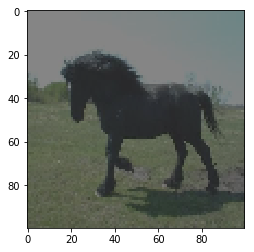

In [13]:
arr = noise_sampler.generate()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
plot(arr)

In [14]:
from pydbm.cnn.convolutionalneuralnetwork.convolutional_auto_encoder import ConvolutionalAutoEncoder as CAE
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2
from pydbm.activation.tanh_function import TanhFunction
from pydbm.activation.identity_function import IdentityFunction
from pydbm.activation.logistic_function import LogisticFunction
from pydbm.loss.mean_squared_error import MeanSquaredError
from pydbm.optimization.optparams.sgd import SGD
from pydbm.optimization.optparams.adam import Adam
from pydbm.cnn.layerablecnn.convolutionlayer.deconvolution_layer import DeconvolutionLayer
from pydbm.synapse.cnn_graph import CNNGraph as DeCNNGraph

from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation

if gray_scale_flag is True:
    channel = 1
else:
    channel = 3
scale = 0.1

conv1 = ConvolutionLayer1(
    ConvGraph1(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

conv2 = ConvolutionLayer2(
    ConvGraph2(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=batch_size,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

deconvolution_layer_list = [DeconvolutionLayer(
    DeCNNGraph(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)]

opt_params=Adam()
convolutional_auto_encoder = CAE(
    layerable_cnn_list=[
        conv1, 
        conv2
    ],
    epochs=100,
    batch_size=batch_size,
    learning_rate=1e-05,
    learning_attenuate_rate=0.1,
    attenuate_epoch=25,
    computable_loss=MeanSquaredError(),
    opt_params=opt_params,
    verificatable_result=VerificateFunctionApproximation(),
    test_size_rate=0.3,
    tol=1e-15,
    save_flag=False
)

generator = Generator(
    batch_size=batch_size,
    learning_rate=1e-05,
    convolutional_auto_encoder=convolutional_auto_encoder,
    deconvolution_layer_list=deconvolution_layer_list,
    gray_scale_flag=gray_scale_flag,
)
generator.noise_sampler = noise_sampler

(20, 3, 100, 100)
(-5.120310526322314, -0.05088537760819707, 4.799509890434539)


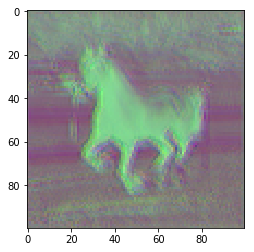

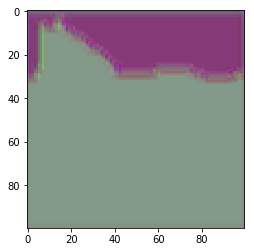

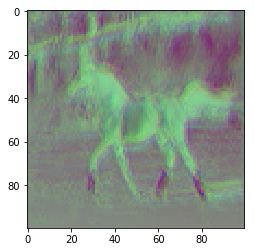

In [15]:
arr = generator.draw()
print(arr.shape)
print((arr.min(), arr.mean(), arr.max()))
plot(arr)

In [18]:
from pydbm.cnn.convolutionalneuralnetwork.convolutionalautoencoder.repelling_convolutional_auto_encoder import RepellingConvolutionalAutoEncoder
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as Dconv1
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as Dconv2

dconv1 = Dconv1(
    ConvGraph1(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=3,
        pad=1
    )
)

dconv2 = Dconv2(
    ConvGraph2(
        activation_function=LogisticFunction(),
        filter_num=batch_size,
        channel=batch_size,
        kernel_size=3,
        scale=scale,
        stride=3,
        pad=1
    )
)

cnn = RepellingConvolutionalAutoEncoder(
    layerable_cnn_list=[
        dconv1, 
        dconv2
    ],
    epochs=100,
    batch_size=batch_size,
    learning_rate=1e-05,
    learning_attenuate_rate=0.1,
    attenuate_epoch=25,
    computable_loss=MeanSquaredError(),
    opt_params=Adam(),
    verificatable_result=VerificateFunctionApproximation(),
    test_size_rate=0.3,
    tol=1e-15,
    save_flag=False
)

opt_params = Adam()
opt_params.dropout_rate = 0.5

scale = 0.01

discriminator = Discriminator(
    convolutional_auto_encoder=cnn,
    batch_size=batch_size,
    learning_rate=1e-05,
    opt_params=opt_params,
)

In [16]:
generator.pre_learn(true_sampler=true_sampler, epochs=100)

Epoch: 0 loss: 0.0014128720166601784
Epoch: 1 loss: 0.0013174253856169293
Epoch: 2 loss: 0.00124147522231066
Epoch: 3 loss: 0.0014012965061008281
Epoch: 4 loss: 0.0013890824899085847
Epoch: 5 loss: 0.001362387073658527
Epoch: 6 loss: 0.0012450914065954386
Epoch: 7 loss: 0.0013832606842143127
Epoch: 8 loss: 0.001463260984440296
Epoch: 9 loss: 0.0014897244842937783
Epoch: 10 loss: 0.0013711828646938004
Epoch: 11 loss: 0.0014250511416285454
Epoch: 12 loss: 0.0014984850587339952
Epoch: 13 loss: 0.0014235191093257865
Epoch: 14 loss: 0.0013978854160139598
Epoch: 15 loss: 0.0012608836107812725
Epoch: 16 loss: 0.001361611840770019
Epoch: 17 loss: 0.00139667250486514
Epoch: 18 loss: 0.0012734736732794712
Epoch: 19 loss: 0.0013757680368960024
Epoch: 20 loss: 0.0013184469357156584
Epoch: 21 loss: 0.0013951602667508518
Epoch: 22 loss: 0.001301629838914693
Epoch: 23 loss: 0.0013251253720098922
Epoch: 24 loss: 0.0014271082471324255
Epoch: 25 loss: 0.002484200716281057
Epoch: 26 loss: 0.0024841477299

(-2.7515189707164738, 1.1179205709292242e-17, 4.1671544020493645)
(-0.02420472104779244, -3.461167965693475e-05, 0.02670423778781005)


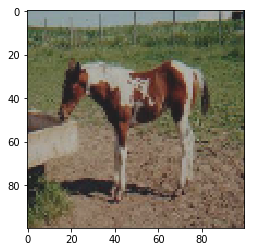

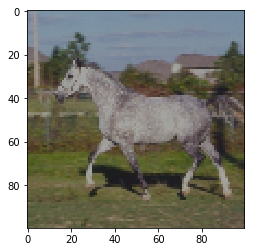

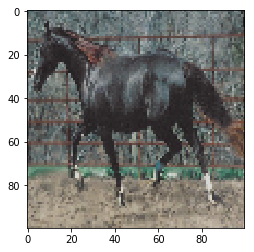

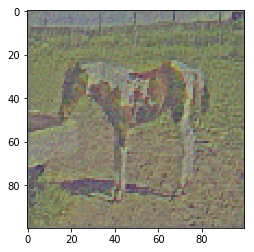

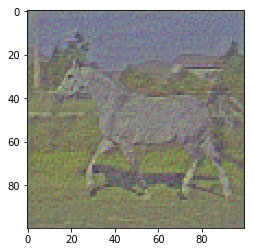

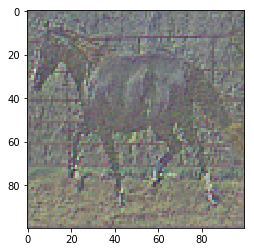

In [19]:
arr = true_sampler.draw()
print((arr.min(), arr.mean(), arr.max()))
r_arr = generator.inference(arr)
print((r_arr.min(), r_arr.mean(), r_arr.max()))
plot(arr)
plot(r_arr)

(20, 3, 100, 100)


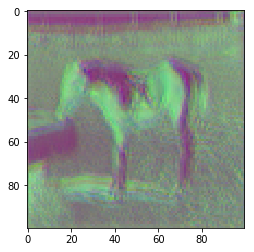

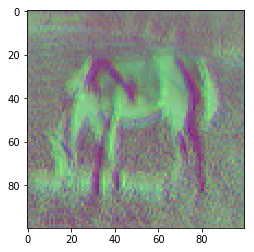

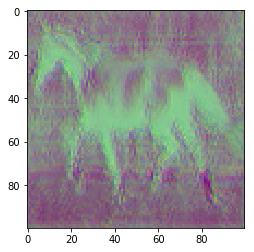

In [20]:
arr = generator.draw()
print(arr.shape)
plot(arr)

In [21]:
from pygan.feature_matching import FeatureMatching

In [23]:
AAE = AdversarialAutoEncoders(gans_value_function=MarginLoss(margin=1.0), feature_matching=FeatureMatching(lambda1=0.01, lambda2=0.99))

In [24]:
generator, discriminator = AAE.train(
    true_sampler=true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=1000,
    k_step=5
)

----------------------------------------------------------------------------------------------------
Iterations: (1/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002486130030040321
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 0.00017356176713163139
And update the `discriminator` by descending its stochastic gradient(means): 0.9998764099102451
Inferenced by the `discriminator` (mean): 0.000181112865942863
And update the `discriminator` by descending its stochastic gradient(means): 0.999863022581506
Inferenced by the `discriminator` (mean): 0.00

And update the `discriminator` by descending its stochastic gradient(means): 0.9998450009312823
Inferenced by the `discriminator` (mean): 0.00011833824262792124
And update the `discriminator` by descending its stochastic gradient(means): 0.9998558830587682
Inferenced by the `discriminator` (mean): 7.743174331095101e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.9998995722592945
Inferenced by the `discriminator` (mean): 0.00010341236754076097
And update the `discriminator` by descending its stochastic gradient(means): 0.9998665347733201
Inferenced by the `discriminator` (mean): 0.00012911947764331495
And update the `discriminator` by descending its stochastic gradient(means): 0.9998351364113548
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024870

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002477939075334174
Inferenced by the `discriminator` (mean): 4.669743547780848e-05
And update the `generator` by descending its stochastic gradient(means): -0.00012931962779075127
----------------------------------------------------------------------------------------------------
Iterations: (10/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024871535530914157
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
------------------------------

----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002487951806451834
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): 1.2148016087221298e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.09985318623054856
Inferenced by the `discriminator` (mean): 2.371235918672462e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.09984104884717883
Inferenced by the `discriminator` (mean): 2.28571850644239e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.09984149648222837
Inferenced by the `discriminator` (mean): -3.259460757582795e-06
And update the `discriminator` by descending its stochastic gradien

Inferenced by the `discriminator` (mean): 1.6641391369624336e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.09982587937376619
Inferenced by the `discriminator` (mean): 8.849431077071838e-06
And update the `discriminator` by descending its stochastic gradient(means): 0.09983274755327218
Inferenced by the `discriminator` (mean): -4.943048830155511e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.09989495169339167
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024796378527491094
Inferenced by the `discriminator` (mean): -5.0939893381212915e-05
And update the `generator` by descending its stochastic gradient(means): -0.00011072968978211775
------------------------------------------------------------------------------

Loss of Feature matching: 0.002473413314795763
Inferenced by the `discriminator` (mean): -4.80433351374091e-05
And update the `generator` by descending its stochastic gradient(means): -0.00012244214127222193
----------------------------------------------------------------------------------------------------
Iterations: (23/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024881313644193243
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -4.096687605479011e-05
And update the `discriminator` by descending its stochastic gradient(means): 0.00987323641

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.0001020765193321697
And update the `discriminator` by descending its stochastic gradient(means): 0.009928261156287702
Inferenced by the `discriminator` (mean): -0.0001520545166477991
And update the `discriminator` by descending its stochastic gradient(means): 0.009980531030347932
Inferenced by the `discriminator` (mean): -0.0001389783065620991
And update the `discriminator` by descending its stochastic gradient(means): 0.009966009255928738
Inferenced by the `discriminator` (mean): -0.0001261352120694264
And update the `discriminator` by descending its stochastic gradient(means): 0.00995829198700224
Inferenced by the `discriminator` (mean): -0.00015521927142440688
And update the `discriminator` by descending its stochastic gradient(means): 0.009982008335307605
--------------------------------------------------------

And update the `discriminator` by descending its stochastic gradient(means): 0.0009701542792310086
Inferenced by the `discriminator` (mean): -0.00013933562828971906
And update the `discriminator` by descending its stochastic gradient(means): 0.0009599997084484809
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002474571931157074
Inferenced by the `discriminator` (mean): -0.00013480305442758388
And update the `generator` by descending its stochastic gradient(means): -5.760296285777348e-05
----------------------------------------------------------------------------------------------------
Iterations: (32/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
--------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (36/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024868291253528825
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.00014091980988473353
And update the `discriminator` by descending its stochastic gradient(means): 0.0009675306415926576
Inferenced by the `discriminator` (mean): -0.00013270722475429913
And update the `discriminator` by descending its stochastic gradient(means): 0.0009456453327209586
Inferenced by the `discriminator`

Inferenced by the `discriminator` (mean): -0.00012810290716539825
And update the `discriminator` by descending its stochastic gradient(means): 0.0009412311319721789
Inferenced by the `discriminator` (mean): -0.00014553978270084105
And update the `discriminator` by descending its stochastic gradient(means): 0.000963196768069482
Inferenced by the `discriminator` (mean): -0.00010924959995284741
And update the `discriminator` by descending its stochastic gradient(means): 0.0009438144724773273
Inferenced by the `discriminator` (mean): -0.00014128894535244823
And update the `discriminator` by descending its stochastic gradient(means): 0.0009623301415254108
Inferenced by the `discriminator` (mean): -0.000145647900826437
And update the `discriminator` by descending its stochastic gradient(means): 0.0009600291911313486
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
-----------------------------------------------------

Inferenced by the `discriminator` (mean): -0.00012986181665730813
And update the `discriminator` by descending its stochastic gradient(means): 6.331027426320042e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024744366840687053
Inferenced by the `discriminator` (mean): -0.00012373978575504733
And update the `generator` by descending its stochastic gradient(means): -6.740805439256493e-05
----------------------------------------------------------------------------------------------------
Iterations: (45/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002488111537

Iterations: (49/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024873942585250425
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.0001489463998082004
And update the `discriminator` by descending its stochastic gradient(means): 7.2123482916863e-05
Inferenced by the `discriminator` (mean): -0.00014835995808199954
And update the `discriminator` by descending its stochastic gradient(means): 6.816163651633604e-05
Inferenced by the `discriminator` (mean): -0.00014681875978981443
And update the `discriminator` by descending its stochastic gradient(me

And update the `discriminator` by descending its stochastic gradient(means): -4.0065906875588815e-05
Inferenced by the `discriminator` (mean): -0.00013868762203490982
And update the `discriminator` by descending its stochastic gradient(means): -3.130794832517206e-05
Inferenced by the `discriminator` (mean): -0.00013280954279855936
And update the `discriminator` by descending its stochastic gradient(means): -2.877975148838145e-05
Inferenced by the `discriminator` (mean): -0.00014123158825770835
And update the `discriminator` by descending its stochastic gradient(means): -2.5035498143756943e-05
Inferenced by the `discriminator` (mean): -0.0001609034549752585
And update the `discriminator` by descending its stochastic gradient(means): 5.000371844731519e-07
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Fe

Inferenced by the `discriminator` (mean): -0.0001319376509221741
And update the `discriminator` by descending its stochastic gradient(means): -3.771555026001292e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002473378070161611
Inferenced by the `discriminator` (mean): -0.000130163688612346
And update the `generator` by descending its stochastic gradient(means): -6.862271424962592e-05
----------------------------------------------------------------------------------------------------
Iterations: (58/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002487307169285

----------------------------------------------------------------------------------------------------
Iterations: (62/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.00248725837709886
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.000133373837196792
And update the `discriminator` by descending its stochastic gradient(means): -3.443455620691012e-05
Inferenced by the `discriminator` (mean): -0.00011593995403641648
And update the `discriminator` by descending its stochastic gradient(means): -6.3003441056109e-05
Inferenced by the `discriminator` (me

Inferenced by the `discriminator` (mean): -0.00012251870043948287
And update the `discriminator` by descending its stochastic gradient(means): -4.931623045574524e-05
Inferenced by the `discriminator` (mean): -0.0001139505751262757
And update the `discriminator` by descending its stochastic gradient(means): -6.903846548677842e-05
Inferenced by the `discriminator` (mean): -0.00013842789549356612
And update the `discriminator` by descending its stochastic gradient(means): -3.120977920972403e-05
Inferenced by the `discriminator` (mean): -0.00013238991270374048
And update the `discriminator` by descending its stochastic gradient(means): -4.5682861529439254e-05
Inferenced by the `discriminator` (mean): -0.0001240840555260756
And update the `discriminator` by descending its stochastic gradient(means): -5.843727175186902e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------

Inferenced by the `discriminator` (mean): -0.0001312998566344413
And update the `discriminator` by descending its stochastic gradient(means): -4.615875996692583e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002473268371406998
Inferenced by the `discriminator` (mean): -0.00013507343553059644
And update the `generator` by descending its stochastic gradient(means): -5.916114125825892e-05
----------------------------------------------------------------------------------------------------
Iterations: (71/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024878187706

----------------------------------------------------------------------------------------------------
Iterations: (75/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002487069920433627
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.00014895687923480034
And update the `discriminator` by descending its stochastic gradient(means): -2.0624213995930975e-05
Inferenced by the `discriminator` (mean): -0.00011406039150611339
And update the `discriminator` by descending its stochastic gradient(means): -6.012496144699262e-05
Inferenced by the `discriminato

Inferenced by the `discriminator` (mean): -0.00012188180461207698
And update the `discriminator` by descending its stochastic gradient(means): -5.039071080101548e-05
Inferenced by the `discriminator` (mean): -0.00014533900436079308
And update the `discriminator` by descending its stochastic gradient(means): -2.455281576068845e-05
Inferenced by the `discriminator` (mean): -0.00011879363893647363
And update the `discriminator` by descending its stochastic gradient(means): -5.2182153503185257e-05
Inferenced by the `discriminator` (mean): -0.00014480538002176242
And update the `discriminator` by descending its stochastic gradient(means): -3.2582811106428564e-05
Inferenced by the `discriminator` (mean): -0.00014333648768194012
And update the `discriminator` by descending its stochastic gradient(means): -3.9559552656355634e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
------------------------------------------

Inferenced by the `discriminator` (mean): -0.00012142884119755182
And update the `discriminator` by descending its stochastic gradient(means): -5.609413694128013e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002470635362980773
Inferenced by the `discriminator` (mean): -0.00012513040714074358
And update the `generator` by descending its stochastic gradient(means): -6.81371943468098e-05
----------------------------------------------------------------------------------------------------
Iterations: (84/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024865326376

----------------------------------------------------------------------------------------------------
Iterations: (88/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024855986011574163
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.00013242533548183766
And update the `discriminator` by descending its stochastic gradient(means): -3.306576773289653e-05
Inferenced by the `discriminator` (mean): -0.00013385592374633834
And update the `discriminator` by descending its stochastic gradient(means): -4.661108155596476e-05
Inferenced by the `discriminato

Inferenced by the `discriminator` (mean): -0.00012154648650707965
And update the `discriminator` by descending its stochastic gradient(means): -5.842945049093337e-05
Inferenced by the `discriminator` (mean): -0.000130726456469903
And update the `discriminator` by descending its stochastic gradient(means): -3.357221760830477e-05
Inferenced by the `discriminator` (mean): -0.00015139506901468518
And update the `discriminator` by descending its stochastic gradient(means): -2.6753813634934583e-05
Inferenced by the `discriminator` (mean): -0.00011364100494090128
And update the `discriminator` by descending its stochastic gradient(means): -7.032552955512477e-05
Inferenced by the `discriminator` (mean): -0.0001314696696657814
And update the `discriminator` by descending its stochastic gradient(means): -4.760735719264656e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
-----------------------------------------------

Inferenced by the `discriminator` (mean): -0.00013461904448070096
And update the `discriminator` by descending its stochastic gradient(means): -4.251927375987017e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024682526881634795
Inferenced by the `discriminator` (mean): -0.0001604108480279852
And update the `generator` by descending its stochastic gradient(means): -3.925922097802396e-05
----------------------------------------------------------------------------------------------------
Iterations: (97/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002486798587

----------------------------------------------------------------------------------------------------
Iterations: (101/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024860675483101328
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.00016135702513764464
And update the `discriminator` by descending its stochastic gradient(means): -5.061913491089343e-06
Inferenced by the `discriminator` (mean): -0.00012419833371651133
And update the `discriminator` by descending its stochastic gradient(means): -5.510525959439334e-05
Inferenced by the `discriminat

Inferenced by the `discriminator` (mean): -0.00013986090877544466
And update the `discriminator` by descending its stochastic gradient(means): -3.985794549395961e-05
Inferenced by the `discriminator` (mean): -0.00014215423654436355
And update the `discriminator` by descending its stochastic gradient(means): -3.696824126543935e-05
Inferenced by the `discriminator` (mean): -0.00014020684999857
And update the `discriminator` by descending its stochastic gradient(means): -2.7176827072347264e-05
Inferenced by the `discriminator` (mean): -0.0001326783243794012
And update the `discriminator` by descending its stochastic gradient(means): -3.822273974385759e-05
Inferenced by the `discriminator` (mean): -0.0001603308079601191
And update the `discriminator` by descending its stochastic gradient(means): -1.7434807271253645e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
------------------------------------------------

Inferenced by the `discriminator` (mean): -0.00016515776494690338
And update the `discriminator` by descending its stochastic gradient(means): -9.043671198517323e-06
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024684893397363505
Inferenced by the `discriminator` (mean): -0.0001478479521762944
And update the `generator` by descending its stochastic gradient(means): -4.542028134354364e-05
----------------------------------------------------------------------------------------------------
Iterations: (110/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.00248601125

----------------------------------------------------------------------------------------------------
Iterations: (114/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002486271696402557
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.00014395840979679694
And update the `discriminator` by descending its stochastic gradient(means): -4.192675049579369e-05
Inferenced by the `discriminator` (mean): -0.00013303766158542058
And update the `discriminator` by descending its stochastic gradient(means): -5.046447398803505e-05
Inferenced by the `discriminato

Inferenced by the `discriminator` (mean): -0.00014706724616425155
And update the `discriminator` by descending its stochastic gradient(means): -2.3335870049641246e-05
Inferenced by the `discriminator` (mean): -0.00014165760589082742
And update the `discriminator` by descending its stochastic gradient(means): -2.0368911785508256e-05
Inferenced by the `discriminator` (mean): -0.0001586479502192182
And update the `discriminator` by descending its stochastic gradient(means): -2.1476419235826843e-05
Inferenced by the `discriminator` (mean): -0.00013660599363125752
And update the `discriminator` by descending its stochastic gradient(means): -3.6209965182041724e-05
Inferenced by the `discriminator` (mean): -0.00017890820559232585
And update the `discriminator` by descending its stochastic gradient(means): 8.78921307028319e-06
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
--------------------------------------------

Inferenced by the `discriminator` (mean): -0.00011406634296733968
And update the `discriminator` by descending its stochastic gradient(means): -6.884780080815584e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002471726640269319
Inferenced by the `discriminator` (mean): -0.00015795511689893667
And update the `generator` by descending its stochastic gradient(means): -3.19194945676671e-05
----------------------------------------------------------------------------------------------------
Iterations: (123/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002485697121

----------------------------------------------------------------------------------------------------
Iterations: (127/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002485869042847405
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.0001306484254972532
And update the `discriminator` by descending its stochastic gradient(means): -3.226518944798748e-05
Inferenced by the `discriminator` (mean): -0.00016477776408861273
And update the `discriminator` by descending its stochastic gradient(means): -1.0645397069307985e-05
Inferenced by the `discriminato

Inferenced by the `discriminator` (mean): -0.00012132175980745388
And update the `discriminator` by descending its stochastic gradient(means): -4.490850546677977e-05
Inferenced by the `discriminator` (mean): -0.00015042051609518966
And update the `discriminator` by descending its stochastic gradient(means): -2.226252213099913e-05
Inferenced by the `discriminator` (mean): -0.0001448325462382291
And update the `discriminator` by descending its stochastic gradient(means): -2.496081655021519e-05
Inferenced by the `discriminator` (mean): -0.00010189639997063738
And update the `discriminator` by descending its stochastic gradient(means): -7.725649176497295e-05
Inferenced by the `discriminator` (mean): -0.0001249796405890352
And update the `discriminator` by descending its stochastic gradient(means): -4.807922705714309e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
-----------------------------------------------

Inferenced by the `discriminator` (mean): -0.0001514259181087847
And update the `discriminator` by descending its stochastic gradient(means): -2.9874117683762863e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.002467162265325616
Inferenced by the `discriminator` (mean): -0.00012312400724754543
And update the `generator` by descending its stochastic gradient(means): -6.475716623386974e-05
----------------------------------------------------------------------------------------------------
Iterations: (136/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.00248491279

----------------------------------------------------------------------------------------------------
Iterations: (140/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.002483472303199571
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.0001842941179449299
And update the `discriminator` by descending its stochastic gradient(means): 1.4457048253439028e-05
Inferenced by the `discriminator` (mean): -0.00011929676872316423
And update the `discriminator` by descending its stochastic gradient(means): -4.813567575658058e-05
Inferenced by the `discriminator

Inferenced by the `discriminator` (mean): -0.00013550533541327169
And update the `discriminator` by descending its stochastic gradient(means): -3.226837828732155e-05
Inferenced by the `discriminator` (mean): -0.00014072936389339735
And update the `discriminator` by descending its stochastic gradient(means): -4.0274465644456086e-05
Inferenced by the `discriminator` (mean): -0.00013176488067465794
And update the `discriminator` by descending its stochastic gradient(means): -3.4741106179364385e-05
Inferenced by the `discriminator` (mean): -0.0001518925040502449
And update the `discriminator` by descending its stochastic gradient(means): -2.8500368201065796e-05
Inferenced by the `discriminator` (mean): -0.00014105148857192418
And update the `discriminator` by descending its stochastic gradient(means): -2.7073890715970175e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
------------------------------------------

Inferenced by the `discriminator` (mean): -0.00014093027249904155
And update the `discriminator` by descending its stochastic gradient(means): -2.6764680426703283e-05
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Loss of Feature matching: 0.0024676729142763185
Inferenced by the `discriminator` (mean): -0.0001324098190186526
And update the `generator` by descending its stochastic gradient(means): -5.150552457901874e-05
----------------------------------------------------------------------------------------------------
Iterations: (149/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024839337

----------------------------------------------------------------------------------------------------
Iterations: (153/1000)
----------------------------------------------------------------------------------------------------
The `auto_encoder`'s turn.
----------------------------------------------------------------------------------------------------
The reconstruction error (mean): 0.0024850809194546294
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Inferenced by the `discriminator` (mean): -0.0001541665464354018
And update the `discriminator` by descending its stochastic gradient(means): -1.0584818535938559e-05
Inferenced by the `discriminator` (mean): -0.0001683880348723999
And update the `discriminator` by descending its stochastic gradient(means): -2.2097026898437085e-06
Inferenced by the `discriminat

Keyboard Interrupt.


(-3.2960998029257023, -1.2505552149377764e-17, 3.3013241801901216)
(-0.02924948832101006, -0.0001855688134661014, 0.02643366416353678)


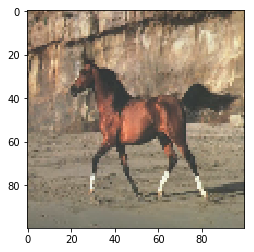

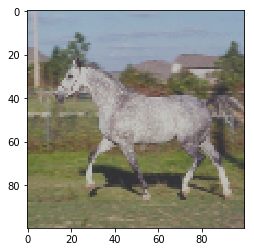

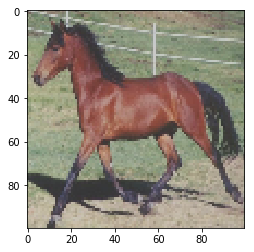

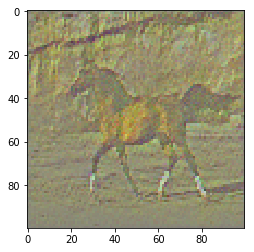

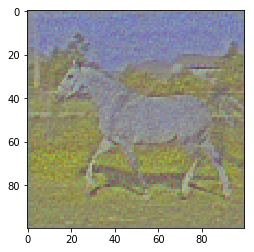

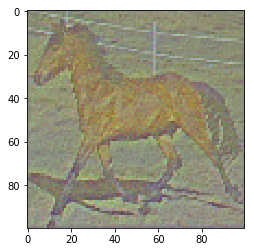

In [25]:
arr = true_sampler.draw()
print((arr.min(), arr.mean(), arr.max()))
r_arr = generator.inference(arr)
print((r_arr.min(), r_arr.mean(), r_arr.max()))
plot(arr)
plot(r_arr)

(20, 3, 100, 100)


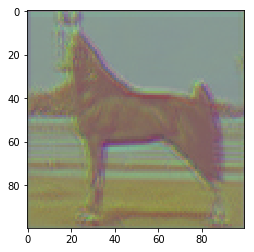

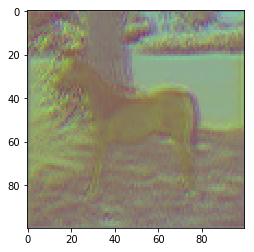

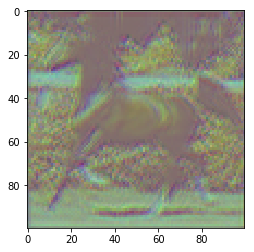

In [26]:
arr = generator.draw()
print(arr.shape)
plot(arr)

Observed data points: 


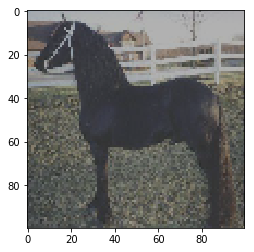

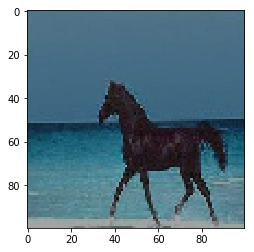

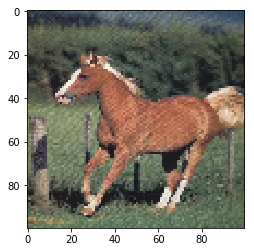

Decoded feature points: 


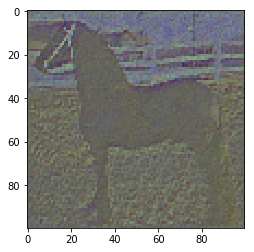

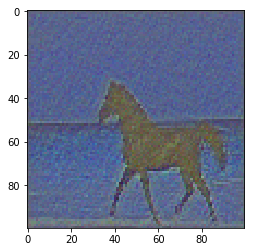

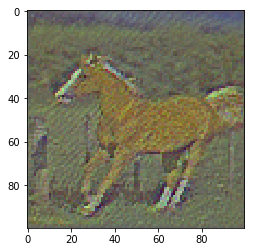

In [27]:
observed_arr = generator.noise_sampler.generate()
decoded_arr = generator.inference(observed_arr)
print("Observed data points: ")
plot(observed_arr)
print("Decoded feature points: ")
plot(decoded_arr)

In [28]:
a_logs_list, d_logs_list, g_logs_list = AAE.extract_logs_tuple()

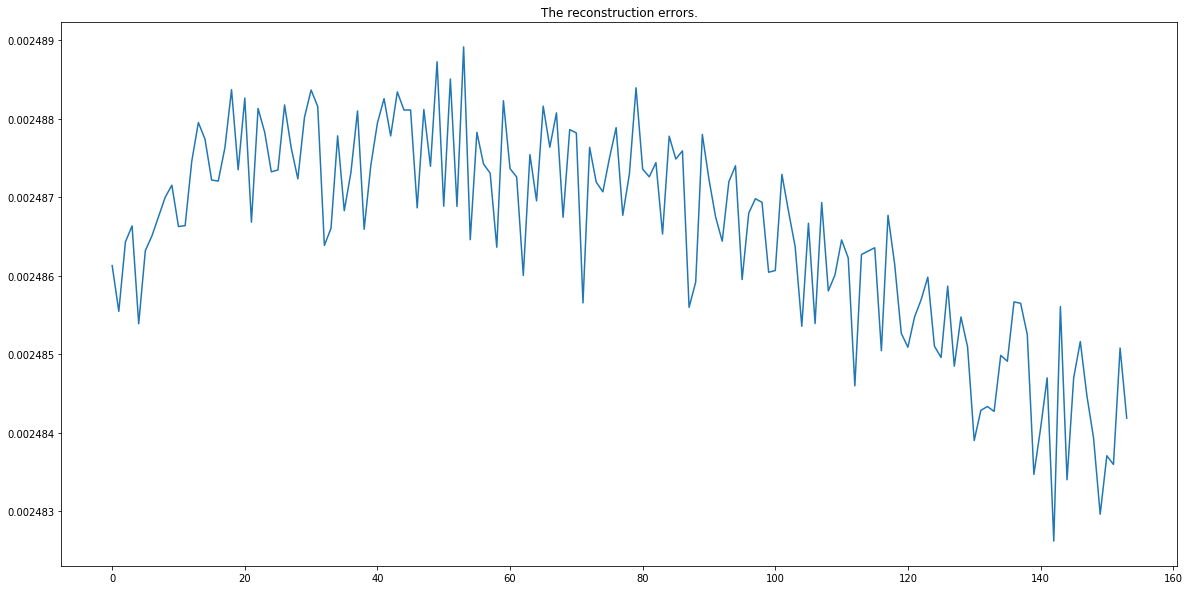

In [29]:
plt.figure(figsize=(20, 10))
plt.title("The reconstruction errors.")
plt.plot(a_logs_list)
plt.show()
plt.close()

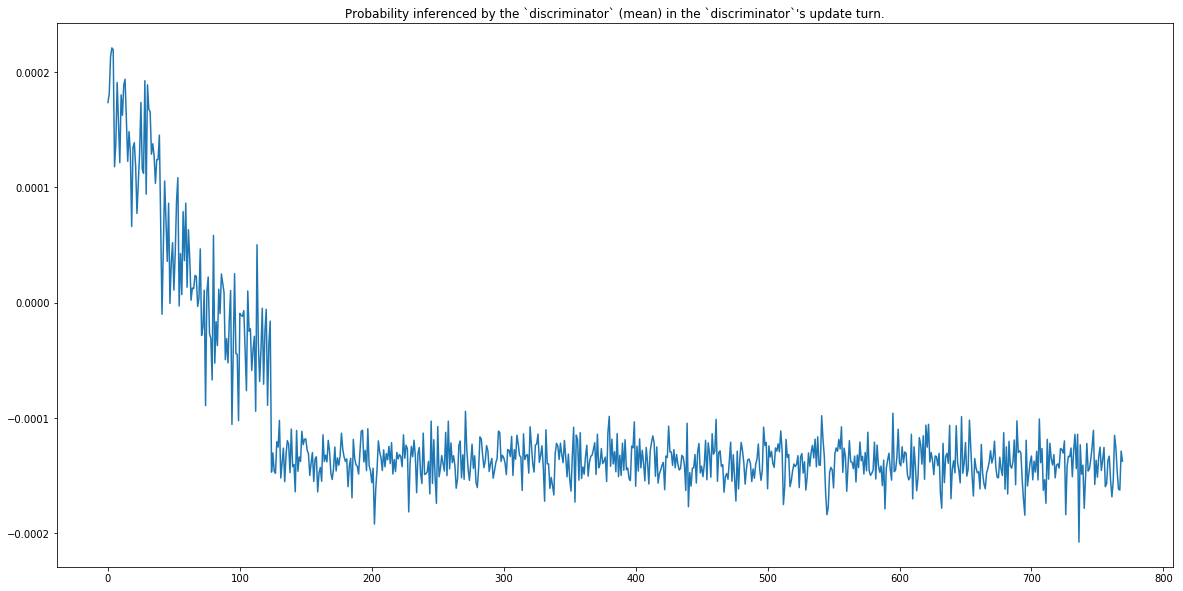

In [30]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list)
plt.show()
plt.close()

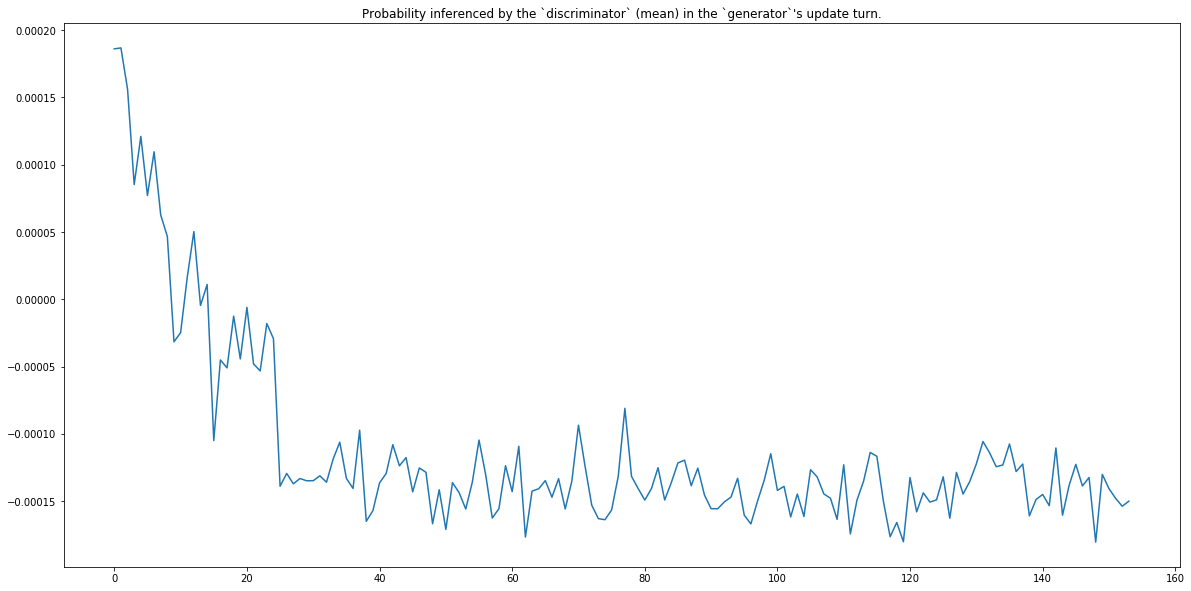

In [33]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list)
plt.show()
plt.close()

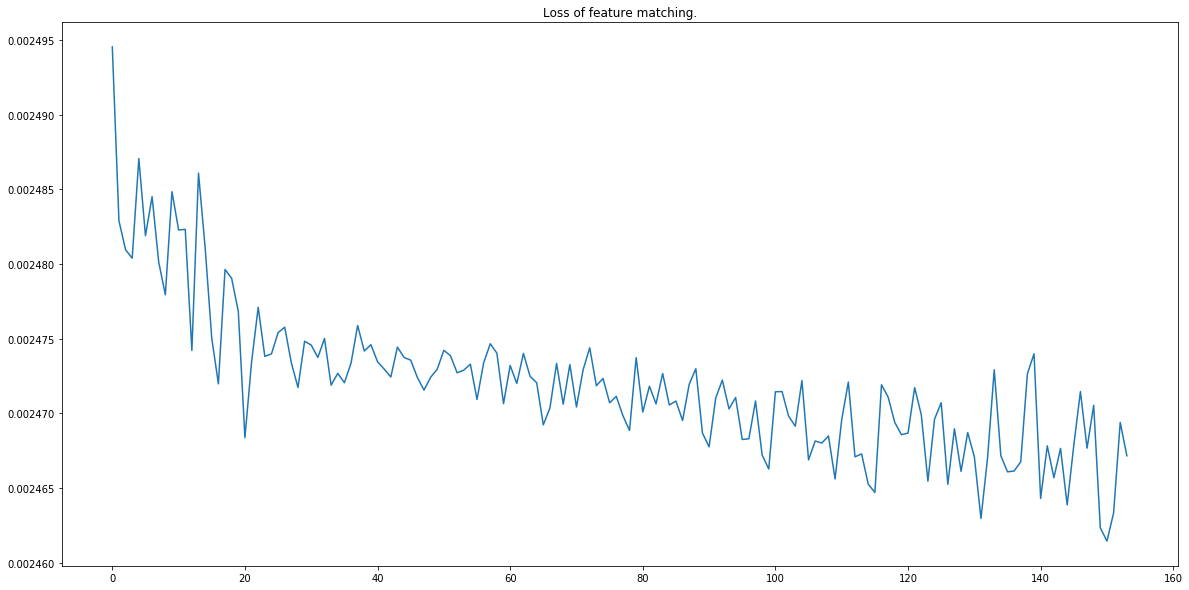

In [35]:
plt.figure(figsize=(20, 10))
plt.title("Loss of feature matching.")
plt.plot(AAE.feature_matching.loss_arr)
plt.show()
plt.close()